# Gerando polígonos de vias no município de São Paulo

A intenção desse notebook é demonstrar e fomentar técnicas de trabalho de geoprocessamento com linguaem de programação, tentando obter um polígono de vias do município de São Paulo utilizando as seguintes camadas do [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos recortar ambas as camadas pela folha número 3316-221 do _SCM_ (Sistema Cartográfico Municipal). Esses arquivos processados estão na pasta gis desse projeto. 

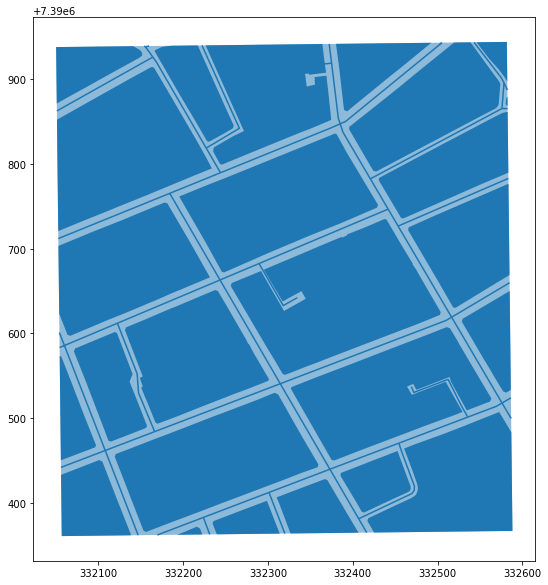

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)


df_scm = gpd.read_file('./gis/scm-3316-221.geojson')
df_quadras = gpd.read_file('./gis/quadras-3316-221.geojson')
df_logradouros = gpd.read_file('./gis/logradouros-3316-221.geojson')

f, ax = plt.subplots(1)
df_scm.plot(ax=ax, alpha=0.5)
df_quadras.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()



## Importando shapefiles para o Postgis

Inicialmente optamos por trabalhar com os dados georeferenciados dentro do banco de dados PostGis. Para isso é necessário importar os Shapefiles para dentro do banco. Neste post é possível aprender [3 maneiras de importar ShapeFiles para dentro do banco de dados PostGis](http://www.clickgeo.com.br/formas-de-importar-shapes-postgis/)



## Trabalhando com o banco de dados PostGis

A primeira estratégia a ser testada vai ser de criar uma geometria única com as ruas que será resultante da intersecção do poígono da SCM total com as quadras. Depois de obtido esse polígono então vamos utilizar o [ST_ApproximateMedialAxis](https://postgis.net/docs/ST_ApproximateMedialAxis.html) para traçar uma rede central e a partir dai tentar dividir o polígono total baseado nos nós de interesecção.

In [2]:
from sqlalchemy import create_engine
from env import *

engine = create_engine("postgresql+psycopg2://%s:%s@%s:%s/%s"%(user, password, host, port, database))
print (engine.table_names())

['quadras-3316-221', 'scm-3316-221', 'sqls_tita', 'scm_1_5000', 'logradouros-3316-221']


### Criando os dataframes pelo Banco de Dados

In [10]:
df_scm = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.scm;", con=engine)
df_quadras = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.quadras;", con=engine)

### Gerando as diferenças entre as feições do SCM com a quadra

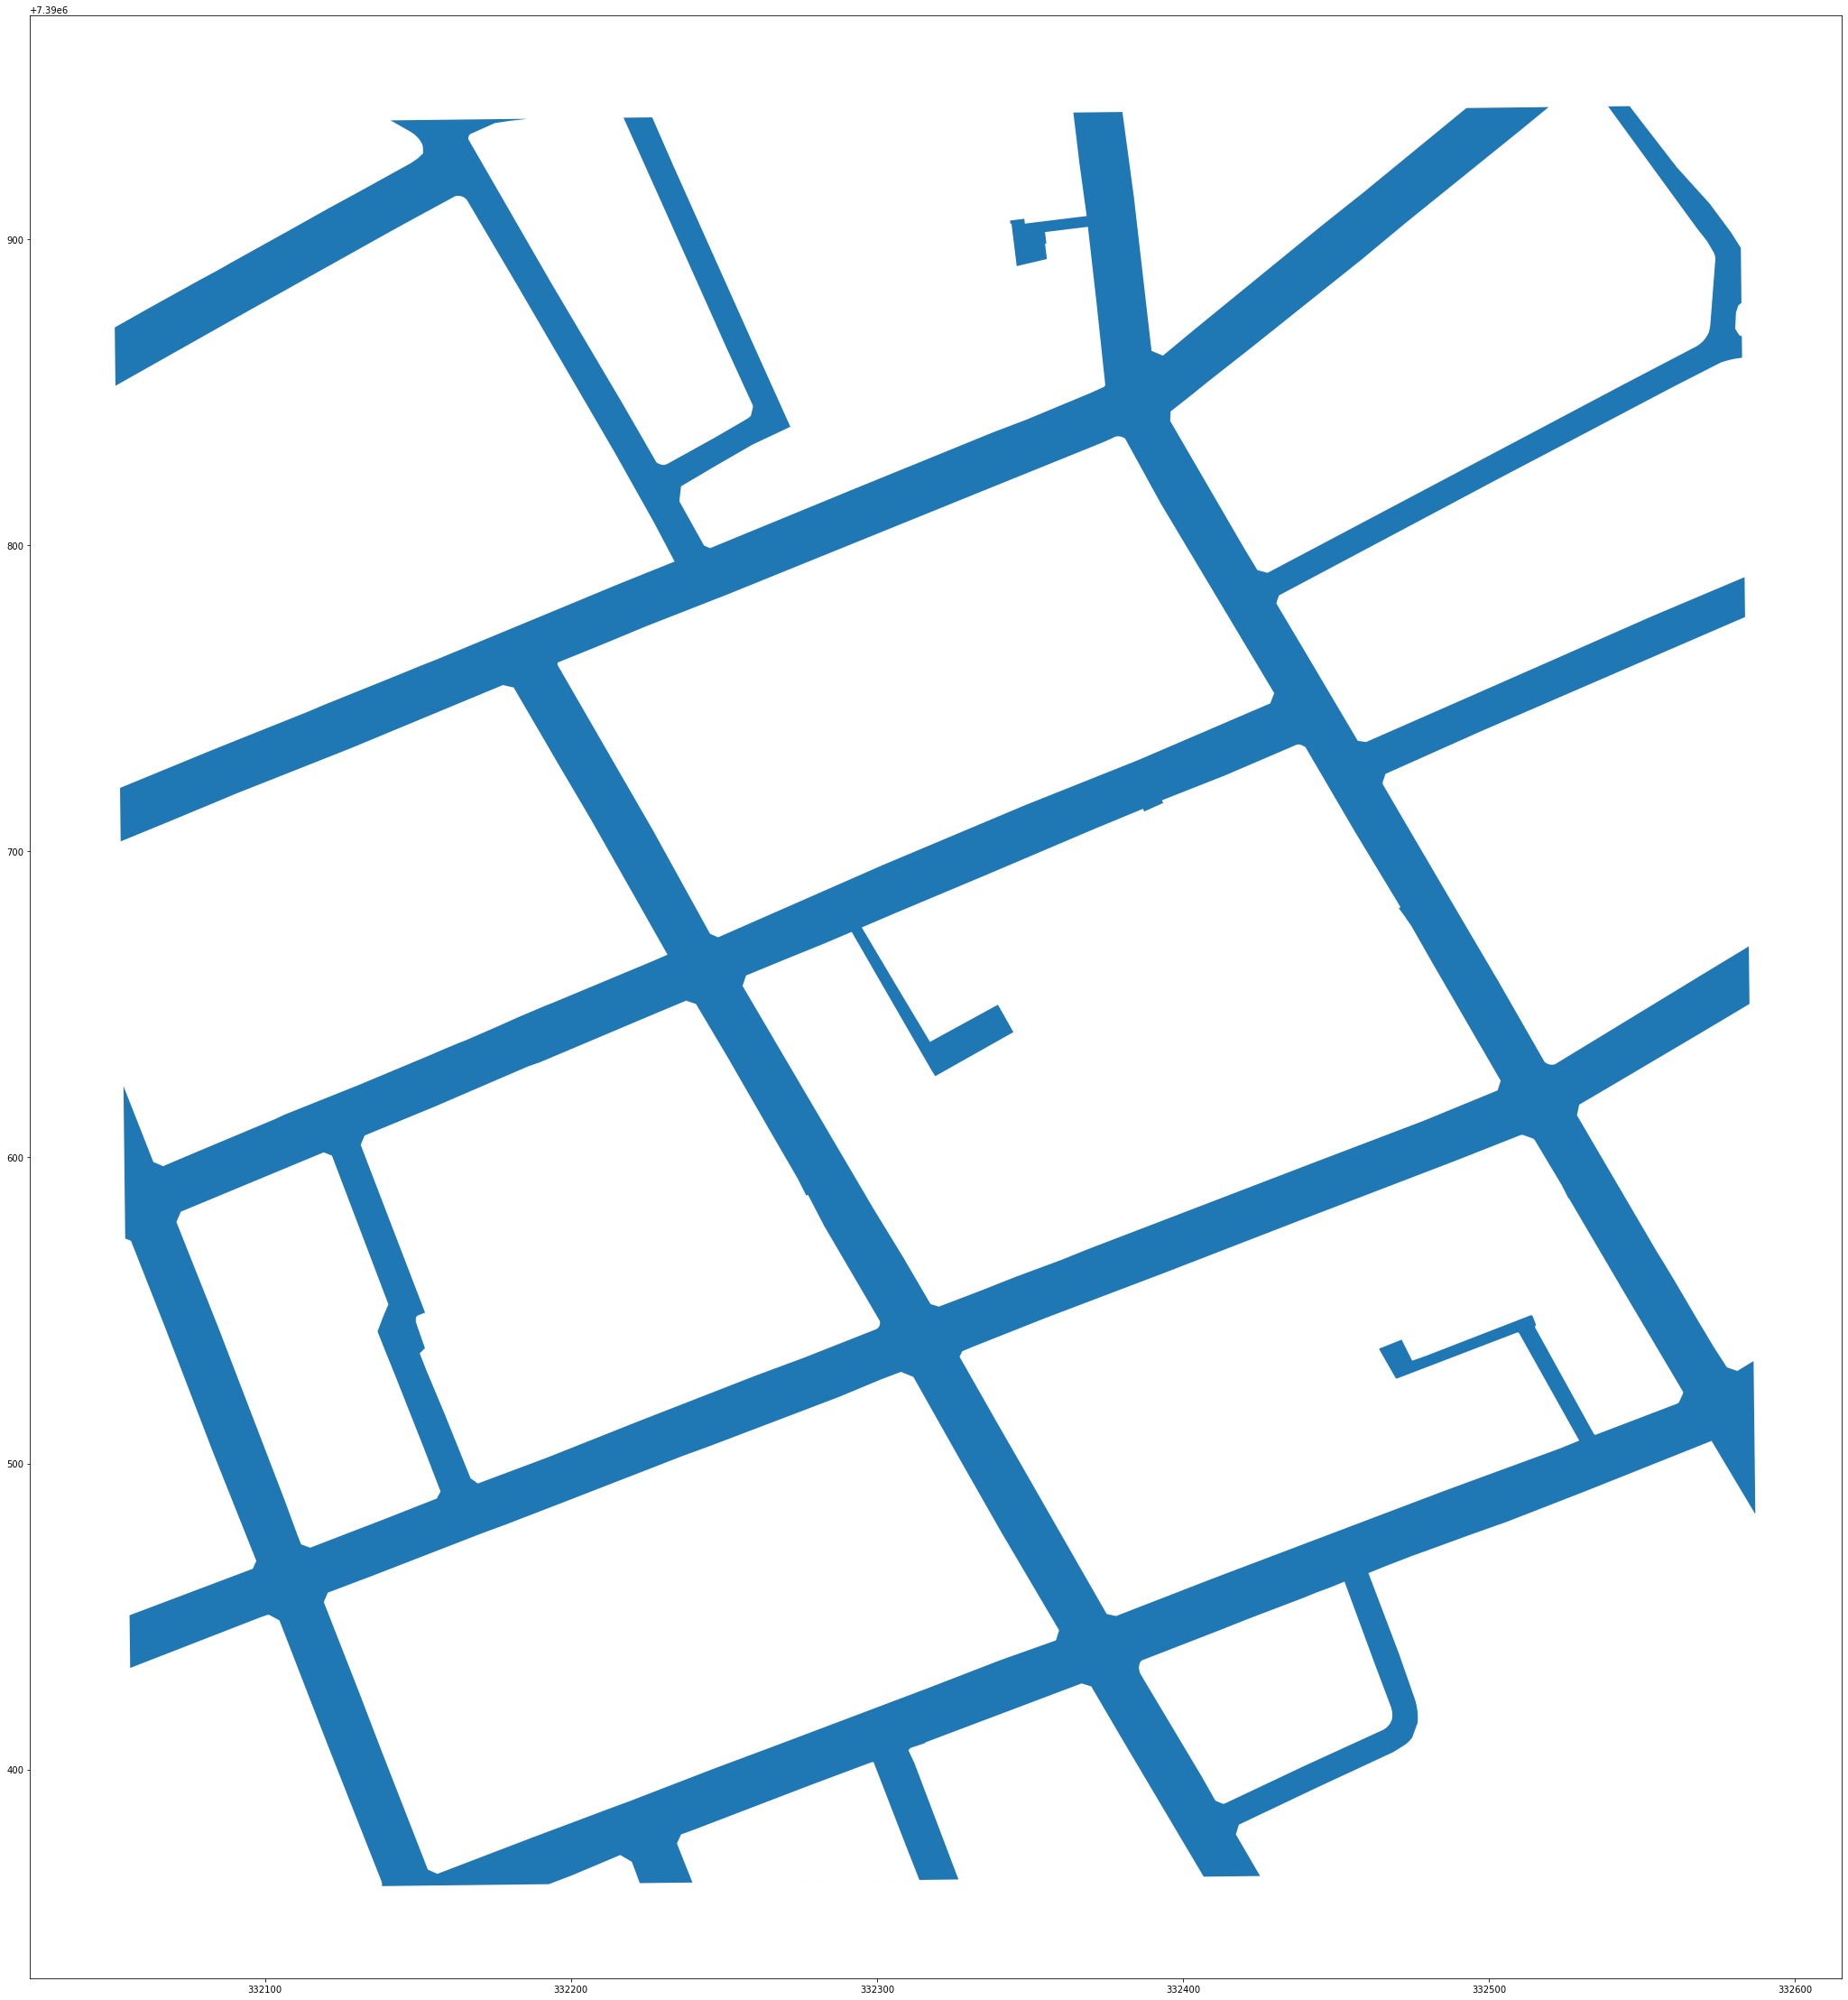

In [21]:
df_vias = gpd.overlay(df_scm, df_quadras, how='difference')
plt.rcParams['figure.figsize'] = (40, 40)
df_vias.plot()